## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.2 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 07:07:50,250] A new study created in memory with name: no-name-4edd12bf-9966-4ad4-b9f9-263dc1d56847


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 07:08:15,506] Trial 0 finished with value: 31.073421332630275 and parameters: {'window_size': 95, 'tcn_filters': 48, 'tcn_kernel_size': 3, 'dropout_rate': 0.15609509189663046, 'attention_dim': 14}. Best is trial 0 with value: 31.073421332630275.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 07:08:27,076] Trial 1 finished with value: 34.61584046137477 and parameters: {'window_size': 71, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.15727784688727336, 'attention_dim': 20}. Best is trial 0 with value: 31.073421332630275.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:08:31,906] Trial 2 finished with value: 42.89787080033569 and parameters: {'window_size': 21, 'tcn_filters': 38, 'tcn_kernel_size': 3, 'dropout_rate': 0.1393953098116545, 'attention_dim': 9}. Best is trial 0 with value: 31.073421332630275.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 07:08:44,225] Trial 3 finished with value: 22.202577145036585 and parameters: {'window_size': 81, 'tcn_filters': 38, 'tcn_kernel_size': 4, 'dropout_rate': 0.19901566983165392, 'attention_dim': 18}. Best is trial 3 with value: 22.202577145036585.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:08:58,453] Trial 4 finished with value: 25.5095649079229 and parameters: {'window_size': 88, 'tcn_filters': 85, 'tcn_kernel_size': 3, 'dropout_rate': 0.1329774335416266, 'attention_dim': 10}. Best is trial 3 with value: 22.202577145036585.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 07:09:15,257] Trial 5 finished with value: 25.11754525852039 and parameters: {'window_size': 74, 'tcn_filters': 98, 'tcn_kernel_size': 3, 'dropout_rate': 0.20362364702073396, 'attention_dim': 32}. Best is trial 3 with value: 22.202577145036585.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:09:18,843] Trial 6 finished with value: 22.854838614773314 and parameters: {'window_size': 12, 'tcn_filters': 83, 'tcn_kernel_size': 5, 'dropout_rate': 0.40054101489517513, 'attention_dim': 19}. Best is trial 3 with value: 22.202577145036585.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:09:25,368] Trial 7 finished with value: 88.19364415242785 and parameters: {'window_size': 26, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.4421899088632957, 'attention_dim': 14}. Best is trial 3 with value: 22.202577145036585.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:09:33,231] Trial 8 finished with value: 10.52861337094356 and parameters: {'window_size': 29, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.143993867140414, 'attention_dim': 30}. Best is trial 8 with value: 10.52861337094356.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:09:46,112] Trial 9 finished with value: 73.42885576579528 and parameters: {'window_size': 84, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.3989287773393224, 'attention_dim': 15}. Best is trial 8 with value: 10.52861337094356.


6/6 [==============================] - 0s 11ms/step


[I 2023-06-14 07:09:58,178] Trial 10 finished with value: 28.02690821555663 and parameters: {'window_size': 45, 'tcn_filters': 114, 'tcn_kernel_size': 5, 'dropout_rate': 0.27121447373621166, 'attention_dim': 29}. Best is trial 8 with value: 10.52861337094356.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 07:10:06,619] Trial 11 finished with value: 16.44076043575377 and parameters: {'window_size': 51, 'tcn_filters': 59, 'tcn_kernel_size': 4, 'dropout_rate': 0.23551289060982136, 'attention_dim': 25}. Best is trial 8 with value: 10.52861337094356.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 07:10:17,334] Trial 12 finished with value: 38.00537813734639 and parameters: {'window_size': 47, 'tcn_filters': 63, 'tcn_kernel_size': 4, 'dropout_rate': 0.25017541471177585, 'attention_dim': 25}. Best is trial 8 with value: 10.52861337094356.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:10:25,816] Trial 13 finished with value: 14.045186616637194 and parameters: {'window_size': 37, 'tcn_filters': 63, 'tcn_kernel_size': 4, 'dropout_rate': 0.10154772984818228, 'attention_dim': 25}. Best is trial 8 with value: 10.52861337094356.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:10:37,383] Trial 14 finished with value: 8.39063515650493 and parameters: {'window_size': 34, 'tcn_filters': 124, 'tcn_kernel_size': 5, 'dropout_rate': 0.10039862353075667, 'attention_dim': 25}. Best is trial 14 with value: 8.39063515650493.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:10:49,717] Trial 15 finished with value: 27.19454148678859 and parameters: {'window_size': 33, 'tcn_filters': 125, 'tcn_kernel_size': 5, 'dropout_rate': 0.3144731174458794, 'attention_dim': 29}. Best is trial 14 with value: 8.39063515650493.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:11:11,767] Trial 16 finished with value: 6.789696117381734 and parameters: {'window_size': 60, 'tcn_filters': 112, 'tcn_kernel_size': 5, 'dropout_rate': 0.1016370520525222, 'attention_dim': 32}. Best is trial 16 with value: 6.789696117381734.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:11:24,880] Trial 17 finished with value: 9.928602630709571 and parameters: {'window_size': 62, 'tcn_filters': 128, 'tcn_kernel_size': 5, 'dropout_rate': 0.10406722519609998, 'attention_dim': 23}. Best is trial 16 with value: 6.789696117381734.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:11:39,896] Trial 18 finished with value: 16.068592949796397 and parameters: {'window_size': 62, 'tcn_filters': 114, 'tcn_kernel_size': 5, 'dropout_rate': 0.1908031466981693, 'attention_dim': 32}. Best is trial 16 with value: 6.789696117381734.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:11:51,700] Trial 19 finished with value: 24.922266363310175 and parameters: {'window_size': 57, 'tcn_filters': 111, 'tcn_kernel_size': 5, 'dropout_rate': 0.3149818950727545, 'attention_dim': 27}. Best is trial 16 with value: 6.789696117381734.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 07:12:03,508] Trial 20 finished with value: 5.426127998676674 and parameters: {'window_size': 40, 'tcn_filters': 104, 'tcn_kernel_size': 5, 'dropout_rate': 0.10084019966402745, 'attention_dim': 22}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:12:12,697] Trial 21 finished with value: 10.99717392896989 and parameters: {'window_size': 40, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.10947023301004549, 'attention_dim': 22}. Best is trial 20 with value: 5.426127998676674.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:12:20,304] Trial 22 finished with value: 11.052880624877002 and parameters: {'window_size': 20, 'tcn_filters': 120, 'tcn_kernel_size': 5, 'dropout_rate': 0.17768471100513838, 'attention_dim': 22}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:12:30,354] Trial 23 finished with value: 13.816383755127218 and parameters: {'window_size': 40, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.10130752677647059, 'attention_dim': 27}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:12:40,996] Trial 24 finished with value: 7.60543905270151 and parameters: {'window_size': 55, 'tcn_filters': 107, 'tcn_kernel_size': 5, 'dropout_rate': 0.1361829942150369, 'attention_dim': 17}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:12:53,359] Trial 25 finished with value: 12.345995765298102 and parameters: {'window_size': 66, 'tcn_filters': 74, 'tcn_kernel_size': 5, 'dropout_rate': 0.17244466732674577, 'attention_dim': 17}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:13:03,110] Trial 26 finished with value: 14.31681739221763 and parameters: {'window_size': 53, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.13777688911055172, 'attention_dim': 12}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:13:13,770] Trial 27 finished with value: 22.28898481820076 and parameters: {'window_size': 55, 'tcn_filters': 92, 'tcn_kernel_size': 5, 'dropout_rate': 0.21908508069880062, 'attention_dim': 16}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:13:22,970] Trial 28 finished with value: 13.913451096302342 and parameters: {'window_size': 45, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.18156895361289066, 'attention_dim': 11}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:13:35,792] Trial 29 finished with value: 9.189827440309136 and parameters: {'window_size': 72, 'tcn_filters': 106, 'tcn_kernel_size': 5, 'dropout_rate': 0.1564866190422221, 'attention_dim': 13}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:13:47,673] Trial 30 finished with value: 10.546775660014617 and parameters: {'window_size': 61, 'tcn_filters': 94, 'tcn_kernel_size': 5, 'dropout_rate': 0.1289069498628066, 'attention_dim': 21}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:13:59,468] Trial 31 finished with value: 8.122507076726695 and parameters: {'window_size': 48, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.12057084641173477, 'attention_dim': 24}. Best is trial 20 with value: 5.426127998676674.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 07:14:41,988] Trial 32 finished with value: 10.545032137385611 and parameters: {'window_size': 99, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.16198613877839735, 'attention_dim': 19}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:14:52,784] Trial 33 finished with value: 16.945359787547297 and parameters: {'window_size': 49, 'tcn_filters': 109, 'tcn_kernel_size': 5, 'dropout_rate': 0.1319270185856246, 'attention_dim': 20}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:15:04,659] Trial 34 finished with value: 6.6064408026204315 and parameters: {'window_size': 67, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.1595656318128543, 'attention_dim': 17}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 07:15:12,624] Trial 35 finished with value: 14.46992516430063 and parameters: {'window_size': 68, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.15350133693781695, 'attention_dim': 17}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 07:15:23,024] Trial 36 finished with value: 33.30256302378915 and parameters: {'window_size': 58, 'tcn_filters': 75, 'tcn_kernel_size': 3, 'dropout_rate': 0.12507386660676081, 'attention_dim': 15}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 07:15:36,572] Trial 37 finished with value: 46.93341206580453 and parameters: {'window_size': 76, 'tcn_filters': 52, 'tcn_kernel_size': 4, 'dropout_rate': 0.15973947502756375, 'attention_dim': 9}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 07:15:58,808] Trial 38 finished with value: 10.0687701929114 and parameters: {'window_size': 77, 'tcn_filters': 102, 'tcn_kernel_size': 3, 'dropout_rate': 0.20660053885574445, 'attention_dim': 19}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 07:16:11,542] Trial 39 finished with value: 11.793320719576036 and parameters: {'window_size': 91, 'tcn_filters': 79, 'tcn_kernel_size': 4, 'dropout_rate': 0.14889270575138114, 'attention_dim': 17}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 4ms/step


[I 2023-06-14 07:16:15,753] Trial 40 finished with value: 37.908915544042976 and parameters: {'window_size': 67, 'tcn_filters': 33, 'tcn_kernel_size': 2, 'dropout_rate': 0.1261362568669563, 'attention_dim': 13}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 07:16:30,445] Trial 41 finished with value: 10.507306153738929 and parameters: {'window_size': 42, 'tcn_filters': 114, 'tcn_kernel_size': 5, 'dropout_rate': 0.1244750598285587, 'attention_dim': 23}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 07:16:43,371] Trial 42 finished with value: 15.720562959803488 and parameters: {'window_size': 52, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.11576034502589748, 'attention_dim': 20}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 07:16:55,554] Trial 43 finished with value: 22.54945776369359 and parameters: {'window_size': 59, 'tcn_filters': 68, 'tcn_kernel_size': 5, 'dropout_rate': 0.14511221536704005, 'attention_dim': 18}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:17:11,781] Trial 44 finished with value: 31.26591199963061 and parameters: {'window_size': 64, 'tcn_filters': 98, 'tcn_kernel_size': 5, 'dropout_rate': 0.17228418227629017, 'attention_dim': 27}. Best is trial 20 with value: 5.426127998676674.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 07:17:24,568] Trial 45 finished with value: 10.570281430863844 and parameters: {'window_size': 27, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.1178301343076247, 'attention_dim': 31}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 07:17:32,810] Trial 46 finished with value: 14.439089937756044 and parameters: {'window_size': 82, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.19265649664840745, 'attention_dim': 23}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:17:54,933] Trial 47 finished with value: 13.020550522989698 and parameters: {'window_size': 47, 'tcn_filters': 111, 'tcn_kernel_size': 4, 'dropout_rate': 0.14131501975144428, 'attention_dim': 15}. Best is trial 20 with value: 5.426127998676674.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 07:18:15,297] Trial 48 finished with value: 10.440281050045137 and parameters: {'window_size': 70, 'tcn_filters': 127, 'tcn_kernel_size': 5, 'dropout_rate': 0.1179480731632524, 'attention_dim': 21}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 07:18:25,418] Trial 49 finished with value: 9.983518446956856 and parameters: {'window_size': 35, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.13917574044659856, 'attention_dim': 18}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 07:18:36,207] Trial 50 finished with value: 16.38349862004045 and parameters: {'window_size': 55, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.10205399442670036, 'attention_dim': 29}. Best is trial 20 with value: 5.426127998676674.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 07:18:44,948] Trial 51 finished with value: 5.992757817196171 and parameters: {'window_size': 30, 'tcn_filters': 123, 'tcn_kernel_size': 5, 'dropout_rate': 0.1194157890601948, 'attention_dim': 24}. Best is trial 20 with value: 5.426127998676674.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 07:18:57,356] Trial 52 finished with value: 14.874475272693417 and parameters: {'window_size': 43, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.11639929662402268, 'attention_dim': 24}. Best is trial 20 with value: 5.426127998676674.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:19:05,372] Trial 53 finished with value: 4.995808430984455 and parameters: {'window_size': 20, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.15869568598428208, 'attention_dim': 26}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:19:17,388] Trial 54 finished with value: 22.374211138663277 and parameters: {'window_size': 16, 'tcn_filters': 111, 'tcn_kernel_size': 5, 'dropout_rate': 0.16951516795262417, 'attention_dim': 26}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 07:19:25,632] Trial 55 finished with value: 14.207517947440756 and parameters: {'window_size': 24, 'tcn_filters': 127, 'tcn_kernel_size': 5, 'dropout_rate': 0.15167518019708004, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:19:38,331] Trial 56 finished with value: 18.923882060635815 and parameters: {'window_size': 10, 'tcn_filters': 124, 'tcn_kernel_size': 5, 'dropout_rate': 0.1859576258922298, 'attention_dim': 30}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:19:50,478] Trial 57 finished with value: 11.464733190003697 and parameters: {'window_size': 17, 'tcn_filters': 82, 'tcn_kernel_size': 5, 'dropout_rate': 0.13797299205573554, 'attention_dim': 21}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:20:00,136] Trial 58 finished with value: 26.202763937960615 and parameters: {'window_size': 31, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.16749244205520547, 'attention_dim': 26}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 07:20:12,138] Trial 59 finished with value: 13.99741348377513 and parameters: {'window_size': 25, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.10419955089387045, 'attention_dim': 22}. Best is trial 53 with value: 4.995808430984455.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 07:20:24,097] Trial 60 finished with value: 18.169052668199388 and parameters: {'window_size': 37, 'tcn_filters': 95, 'tcn_kernel_size': 5, 'dropout_rate': 0.20479873968075907, 'attention_dim': 31}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:20:33,716] Trial 61 finished with value: 8.955415034618486 and parameters: {'window_size': 30, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.11253213922440765, 'attention_dim': 24}. Best is trial 53 with value: 4.995808430984455.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 07:20:56,394] Trial 62 finished with value: 14.756395459513296 and parameters: {'window_size': 50, 'tcn_filters': 123, 'tcn_kernel_size': 5, 'dropout_rate': 0.13207442899614047, 'attention_dim': 24}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:21:08,382] Trial 63 finished with value: 13.310235966146164 and parameters: {'window_size': 21, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.14922824265951504, 'attention_dim': 26}. Best is trial 53 with value: 4.995808430984455.


6/6 [==============================] - 0s 11ms/step


[I 2023-06-14 07:21:20,378] Trial 64 finished with value: 11.999564719869763 and parameters: {'window_size': 37, 'tcn_filters': 115, 'tcn_kernel_size': 5, 'dropout_rate': 0.10036267863985752, 'attention_dim': 22}. Best is trial 53 with value: 4.995808430984455.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 07:21:32,610] Trial 65 finished with value: 15.776488974700017 and parameters: {'window_size': 47, 'tcn_filters': 112, 'tcn_kernel_size': 5, 'dropout_rate': 0.16198670567456397, 'attention_dim': 16}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:21:39,776] Trial 66 finished with value: 5.79737434658197 and parameters: {'window_size': 15, 'tcn_filters': 120, 'tcn_kernel_size': 5, 'dropout_rate': 0.12590638251153166, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:21:46,678] Trial 67 finished with value: 6.969439649038759 and parameters: {'window_size': 14, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.134111591641609, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:21:52,154] Trial 68 finished with value: 5.065315476256313 and parameters: {'window_size': 16, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.11173444154544893, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 07:21:59,048] Trial 69 finished with value: 5.825810043268332 and parameters: {'window_size': 20, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.11186041544836853, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 07:22:11,790] Trial 70 finished with value: 8.76667139711861 and parameters: {'window_size': 18, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.11540976350047571, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:22:20,074] Trial 71 finished with value: 7.992431618428303 and parameters: {'window_size': 13, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.1084819985470338, 'attention_dim': 30}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 07:22:26,950] Trial 72 finished with value: 7.411988829067721 and parameters: {'window_size': 22, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.12757463184285803, 'attention_dim': 32}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:22:34,395] Trial 73 finished with value: 5.854519310841444 and parameters: {'window_size': 10, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.11089421848431635, 'attention_dim': 27}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:22:39,362] Trial 74 finished with value: 7.638057612918099 and parameters: {'window_size': 10, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.15320598731088764, 'attention_dim': 27}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:22:47,404] Trial 75 finished with value: 9.704835126519225 and parameters: {'window_size': 19, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.12377442357079939, 'attention_dim': 29}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:22:53,995] Trial 76 finished with value: 11.267479233748643 and parameters: {'window_size': 15, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.1800348264614055, 'attention_dim': 25}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:23:03,038] Trial 77 finished with value: 10.702839944785415 and parameters: {'window_size': 23, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.11184004062257241, 'attention_dim': 27}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:23:12,927] Trial 78 finished with value: 15.080892161123453 and parameters: {'window_size': 12, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.1467646906193371, 'attention_dim': 26}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:23:20,598] Trial 79 finished with value: 24.44075665212677 and parameters: {'window_size': 27, 'tcn_filters': 109, 'tcn_kernel_size': 3, 'dropout_rate': 0.13508266721186085, 'attention_dim': 8}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:23:27,392] Trial 80 finished with value: 32.52185148966088 and parameters: {'window_size': 19, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.1594035404993803, 'attention_dim': 28}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:23:39,621] Trial 81 finished with value: 12.551472613700236 and parameters: {'window_size': 28, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.10971930978759875, 'attention_dim': 31}. Best is trial 53 with value: 4.995808430984455.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:23:46,539] Trial 82 finished with value: 4.4131708188828105 and parameters: {'window_size': 12, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.10070633082384911, 'attention_dim': 25}. Best is trial 82 with value: 4.4131708188828105.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 07:23:53,167] Trial 83 finished with value: 7.619582469436578 and parameters: {'window_size': 13, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.12310583356316179, 'attention_dim': 25}. Best is trial 82 with value: 4.4131708188828105.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:24:00,021] Trial 84 finished with value: 4.083767689491196 and parameters: {'window_size': 16, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.10012708541601573, 'attention_dim': 25}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 07:24:06,849] Trial 85 finished with value: 5.380029306359212 and parameters: {'window_size': 17, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.10013009903952776, 'attention_dim': 23}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:24:19,900] Trial 86 finished with value: 8.400021052005066 and parameters: {'window_size': 16, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.10072697157579794, 'attention_dim': 23}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:24:27,012] Trial 87 finished with value: 7.711042480588086 and parameters: {'window_size': 11, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.11129309250680647, 'attention_dim': 25}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:24:38,818] Trial 88 finished with value: 8.161849191153525 and parameters: {'window_size': 21, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.1004858908130434, 'attention_dim': 29}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 07:24:45,679] Trial 89 finished with value: 7.189370221386012 and parameters: {'window_size': 15, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.1273983618490247, 'attention_dim': 26}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:24:52,295] Trial 90 finished with value: 7.474039297920981 and parameters: {'window_size': 18, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.11042625172927131, 'attention_dim': 28}. Best is trial 84 with value: 4.083767689491196.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:24:58,654] Trial 91 finished with value: 3.844014787717279 and parameters: {'window_size': 13, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.12190859607012922, 'attention_dim': 24}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:25:06,622] Trial 92 finished with value: 16.58296229224828 and parameters: {'window_size': 13, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.14287589249474061, 'attention_dim': 27}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 07:25:13,131] Trial 93 finished with value: 6.625150277681272 and parameters: {'window_size': 17, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.11942366129859129, 'attention_dim': 23}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 07:25:21,374] Trial 94 finished with value: 11.079861706369233 and parameters: {'window_size': 10, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.13243237207992833, 'attention_dim': 25}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 07:25:33,403] Trial 95 finished with value: 5.599871350252202 and parameters: {'window_size': 20, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.10901854381767466, 'attention_dim': 26}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:25:40,399] Trial 96 finished with value: 6.682897216778364 and parameters: {'window_size': 25, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.12199125949749157, 'attention_dim': 26}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:25:47,961] Trial 97 finished with value: 7.728752584579905 and parameters: {'window_size': 20, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.142930256141651, 'attention_dim': 22}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:25:59,880] Trial 98 finished with value: 11.794887378596489 and parameters: {'window_size': 24, 'tcn_filters': 109, 'tcn_kernel_size': 3, 'dropout_rate': 0.10015453179586546, 'attention_dim': 24}. Best is trial 91 with value: 3.844014787717279.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:26:04,356] Trial 99 finished with value: 4.521072488461632 and parameters: {'window_size': 15, 'tcn_filters': 115, 'tcn_kernel_size': 4, 'dropout_rate': 0.13050624929164728, 'attention_dim': 25}. Best is trial 91 with value: 3.844014787717279.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 13, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.12190859607012922, 'attention_dim': 24}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.056029747769492835
RMSE on Test dataset:  1.9606159204998002
MSLE on Test dataset:  0.004492337983813609


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 18ms/step


## Visualization

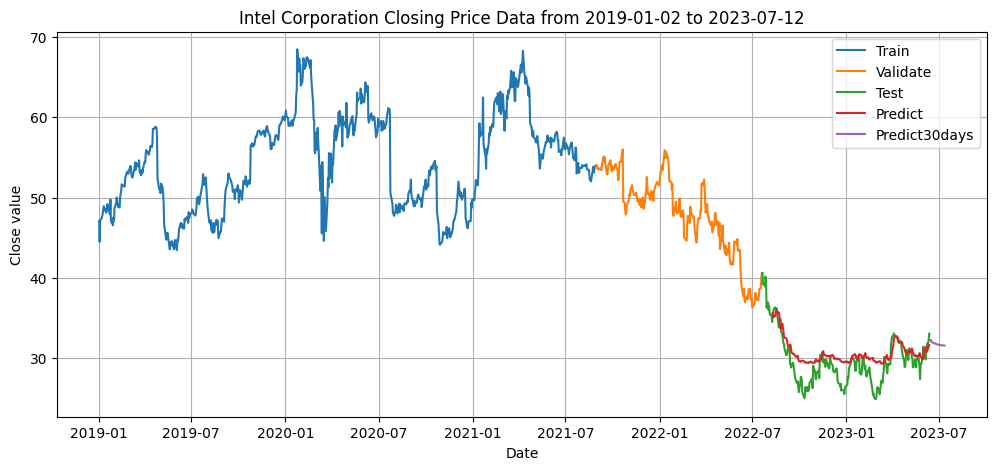

In [21]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], best_y_pred)

plt.plot(index_next_30_days, scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)))

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_INTC.png')
plt.show()